# Evaluating scaffold-based splitting

As an additional validation step to leave-one-out cross-validation plus holdout, we are going to test the generalization capabilities of our SVR model by scaffolding the molecules in our dataset and using those divisions as the folds for our validation. This way, we will train our model with some molecules and test them with unrelated molecules from a different scaffold that the model is not familiar with. 

## Importing modules and reading the dataset

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from mlworkflow.models.regression_models import SVRModel, LinRegModel
from mlworkflow.models.metrics import Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score, mean_squared_error

from rdkit import Chem
from rdkit.Chem.Draw import MolsMatrixToGridImage, MolsToGridImage
from IPython.display import display

In [4]:
df = pd.read_csv('./df_trim_boril.csv')
df.dropna(axis='rows', inplace=True)
df.reset_index(inplace=True)
# df = df.sample(frac=1, random_state=42)  # Shuffle the dataset
# Add white noise to the 98:2 and 99:1 extremes
df.loc[df['ratio'] < -2.2, 'ratio'] = df.loc[df['ratio'] < -2.2, 'ratio'] + np.random.normal(0, 0.1, len(df.loc[df['ratio'] < -2.2, 'ratio']))

feature_var = ['Solid_angle_G_Emin_ligand', 'nucleofug_Boltz_ligand', 'IP_Boltz_react', 'Sterimol_B_1_Boltz_ligand', 'nucleo_Emin_react', 'Dispersion_area_Boltz_ligand', 'Pyr_P_Boltz_react', 'Sterimol_bur_B_5_Boltz_react', 'Pyr_alpha_Boltz_react', 'VBur_Emin_ligand', 'Sterimol_bur_B_5_Emin_react', 'Dispersion_area_Emin_ligand', 'Solid_angle_Boltz_ligand', 'Sterimol_B_1_Emin_ligand', 'Solid_angle_Emin_ligand', 'Pyr_alpha_Emin_react', 'Solid_angle_G_Boltz_ligand', 'Sterimol_bur_B_1_Boltz_ligand', 'HOMO_Boltz_react']
obj_var = ['ratio']

## Ligand based division
In this scenario, we will divide our dataset based on the ligands used. This division will work as the folds in our cross-validation: a certain ligand will be excluded from the dataset for validation and the rest will be used for training the model. This will allow us to see how well can the model generalize to unseen ligands, while not compromising the size of the training dataset severely. 

In [258]:
def normalize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    
    return Chem.rdmolfiles.MolToSmiles(m)

df['smiles_ligand_canon'] = [normalize_smiles(x) for x in df['smiles_ligand']]
scaffolds = df['smiles_ligand_canon'].unique()

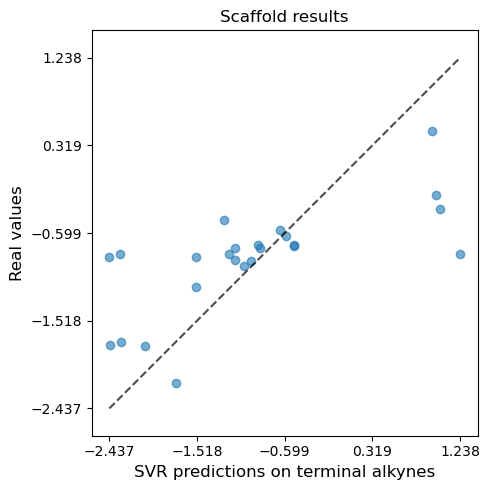

R2 score: 0.44791322471597483


In [307]:
# Test first ligand scaffold
metrics = Metrics(plot_res=False)
m = SVRModel(components=[MinMaxScaler()])
m.obj_var = obj_var
m.feature_var = feature_var

train_index = df[-(df['smiles_ligand_canon'] == scaffolds[1])].index
test_index = df[df['smiles_ligand_canon'] == scaffolds[1]].index
score, preds = m.eval_data(df, train_index, test_index, metrics, print_res=False)

error_plot(df.iloc[test_index][obj_var], preds, 'SVR predictions on terminal alkynes')
print(f'R2 score: {r2_score(df.iloc[test_index][obj_var], preds)}')

In [308]:
# Evaluate all ligand scaffolds
rmse = lambda orig, pred: np.sqrt(mean_squared_error(orig, pred))
rmse_acu = []
for s in scaffolds:
    metrics = Metrics(plot_res=False)
    m = SVRModel(components=[MinMaxScaler()])
    m.obj_var = obj_var
    m.feature_var = feature_var

    train_index = df[-(df['smiles_ligand_canon'] == s)].index
    test_index = df[df['smiles_ligand_canon'] == s].index
    score, preds = m.eval_data(df, train_index, test_index, metrics, print_res=False)

    rmse_acu = rmse_acu + [rmse(df.iloc[test_index][obj_var], preds)]
    
print(f'Final RMSE score: {np.mean(rmse_acu):.2f}')

Final RMSE score: 0.46


The final root mean squared error of the cross-validation based on ligands has a very similar error to that of the original leave-one-out cross-validation of the model, and the model is subsequently able to predict the ratio values of unseen ligands. This type of validation however is more akin to evaluating the extrapolation capabilities of the model rather than validating its performance on similarly sampled and distributed train and test datasets.

## Alkyne type division
In this additional scenario, we will try to go a step further and divide the original dataset based on the different characteristics that our alkyne reactants can have, such as whether they are terminal or internal alkynes or whether they are located in between an oxygen and an aromatic ring or not. This type of division generates rather large test datasets, which can be an issue when paired with our reduced total number of instances.

In [309]:
# Identify substructures with rdkit

def check_alkyne_type(smiles, substruct, wildcard=False):
    alkyne = Chem.MolFromSmiles(substruct)
    if wildcard:
        p = Chem.AdjustQueryParameters.NoAdjustments()
        p.makeDummiesQueries = True
        p.makeAtomsGeneric = True
        alkyne = Chem.AdjustQueryProperties(alkyne, p)
    m = Chem.MolFromSmiles(smiles)
    
    return m.HasSubstructMatch(alkyne)

internal = '*-C#C-*'
oxy_ring = 'OCC#CC1=CC=CC=C1'

In [311]:
# Train and test based on scaffolds of alkyne type
df['alkyne_internal'] = [check_alkyne_type(x, internal, wildcard=True) for x in df['smiles_react']]
df['alkyne_oxy_ring'] = [check_alkyne_type(x, oxy_ring) for x in df['smiles_react']]

In [313]:
def error_plot(orig, preds, label, title="Scaffold results"):
    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        preds, orig, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.6}
    )
    ax.set_title(title, size=12)
    ax.set_xlabel(label, size=12)
    ax.set_ylabel(f'Real values', size=12)
    plt.tight_layout()
    plt.show()
    # plt.savefig("pred.pdf")

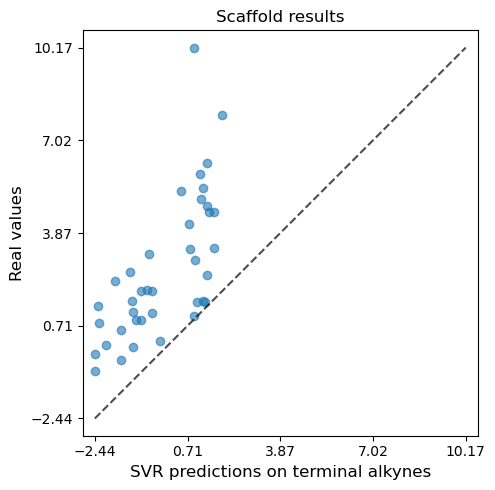

R2 score: -4.597828669969125
96 train data points, 39 test data points. 28.89%


In [316]:
# Test terminals
metrics = Metrics(plot_res=False)
m = SVRModel(components=[MinMaxScaler()])
m.obj_var = obj_var
m.feature_var = feature_var

train_index = df[df['alkyne_internal']].index
test_index = df[-df['alkyne_internal']].index
score, preds = m.eval_data(df, train_index, test_index, metrics, print_res=False)

error_plot(df.iloc[test_index][obj_var], preds, 'SVR predictions on terminal alkynes')
print(f'R2 score: {r2_score(df.iloc[test_index][obj_var], preds)}')
print(f'{len(train_index)} train data points, {len(test_index)} test data points. {len(test_index) * 100 / (len(test_index) + len(train_index)):.2f}%')

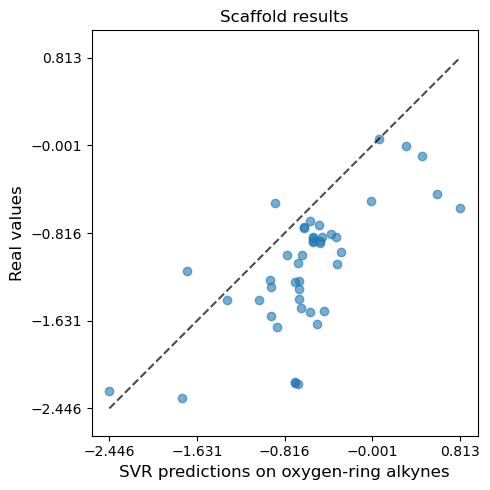

R2 score: -0.5305351861326246
90 train data points, 45 test data points. 33.33%


In [317]:
# Test oxygen rings
metrics = Metrics(plot_res=False)
m = SVRModel(components=[MinMaxScaler()])
m.obj_var = obj_var
m.feature_var = feature_var

train_index = df[-df['alkyne_oxy_ring']].index
test_index = df[df['alkyne_oxy_ring']].index
score, preds = m.eval_data(df, train_index, test_index, metrics, print_res=False)

error_plot(df.iloc[test_index][obj_var], preds, 'SVR predictions on oxygen-ring alkynes')
print(f'R2 score: {r2_score(df.iloc[test_index][obj_var], preds)}')
print(f'{len(train_index)} train data points, {len(test_index)} test data points. {len(test_index) * 100 / (len(test_index) + len(train_index)):.2f}%')

As expected, the model is not able to extrapolate accurate enough predictions with the splits based on alkyne type. With our reduced number of instances, extracting a unique set of 30% of our data points for testing purposes proves to be too much loss of information and the models are not able to be properly fitted for the task of predicting the ratio of unseen alkynes.